##  Travel Agent 최종 버전
- 호출되는 tool 정보 및 정상 호출 여부를 체크할 수 있도록 log 출력
- 각각의 툴에 logging 함수를 wrapping 한다.

In [1]:
from dotenv import load_dotenv

# .env 파일의 환경변수를 기존 값과 상관없이 덮어쓰기
load_dotenv(override=True)

True

In [2]:
# 에이전트 실행 시 로깅을 활성화
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Debug 모드로 실행할 경우 다음 주석 해제 후 실행
# from langchain.globals import set_debug
# set_debug(True)

In [3]:
from collections import defaultdict
import traceback
from langchain_core.tools import Tool

_call_counts = defaultdict(int)

def wrap_func_with_logging(original_func, tool_name):
    def wrapped(input, *, config=None):
        _call_counts[tool_name] += 1
        call_id = _call_counts[tool_name]
        print(f"[🛠️ {tool_name}] Call #{call_id} - Called with input: {repr(input)}")
        try:
            result = original_func(input)
            
            # 결과에 에러가 포함되어 있는지 확인
            result_str = str(result)
            if result and not any(error_keyword in result_str for error_keyword in ['HTTPError', 'Error:', 'error:', 'Exception', 'Failed']):
                print(f"[✅ {tool_name}] Call #{call_id} - Success. Result: {result_str[:300]}")
            elif result:
                print(f"[❌ {tool_name}] Call #{call_id} - API Error in result: {result_str[:300]}")
            else:
                print(f"[⚠️ {tool_name}] Call #{call_id} - No result returned.")
            return result
        except Exception as e:
            print(f"[❌ {tool_name}] Call #{call_id} - Error: {e}")
            print(traceback.format_exc())
            raise
    return wrapped


def logging_tool(func, name, description):

    if callable(func) and not hasattr(func, "invoke"):
        # 순수 함수형 도구
        func = wrap_func_with_logging(func, name)
        return Tool(name=name, func=func, description=description)

    elif hasattr(func, "invoke"):
        # LangChain-style Tool → 직접 감싸지 말고 아예 래핑된 Tool을 새로 정의
        class WrappedTool(func.__class__):
            def invoke(self, input, config=None):
                _call_counts[name] += 1
                call_id = _call_counts[name]
                print(f"[🛠️ {name}] Call #{call_id} - Called with input: {repr(input)}")
                try:
                    result = super().invoke(input, config=config)
                    
                    # 결과에 에러가 포함되어 있는지 확인
                    result_str = str(result)
                    if result and not any(error_keyword in result_str for error_keyword in ['HTTPError', 'Error:', 'error:', 'Exception', 'Failed']):
                        print(f"[✅ {name}] Call #{call_id} - Success. Result: {result_str[:300]}")
                    elif result:
                        print(f"[❌ {name}] Call #{call_id} - API Error in result: {result_str[:300]}")
                    else:
                        print(f"[⚠️ {name}] Call #{call_id} - No result returned.")
                    return result
                except Exception as e:
                    print(f"[❌ {name}] Call #{call_id} - Error: {e}")
                    print(traceback.format_exc())
                    raise

        return WrappedTool(name=name, description=description)

    else:
        raise ValueError("func must be a callable or have an .invoke() method")


In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 원래 tavily tool 정의는 다음 3줄이면 가능하지만
# tavily_search = TavilySearchResults(max_results=3)
# # 웹 검색 도구 tavily의 이름과 설명을 설정합니다.
# tavily_search.name = "tavily_search"
# tavily_search.description = "Use this tool to search on the web using tavily"

# 로그를 찍기 위해 logging_tool 함수로 래핑
tavily_search = logging_tool(
    name="tavily_search",
    func=TavilySearchResults(max_results=3),
    description="Search with Tavily"
)

/var/folders/j1/rm0gdwk50j339fwgq9nr34t40000gn/T/ipykernel_73122/2386748563.py:12: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  func=TavilySearchResults(max_results=3),


In [5]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper_search = logging_tool(
    name="serper_search",
    func=GoogleSerperAPIWrapper().run,
    description="Search with Serper"
)

In [6]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper_places = logging_tool(
        name="serper_places",
        func=GoogleSerperAPIWrapper(type="places").run,
        description="Use this tool to get information of the place",
    )

In [7]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia_search = logging_tool(
    name="wikipedia_search",
    func=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run,
    description="Use this tool to search on the wikipedia"
)

In [8]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper

weather_search = logging_tool(
    name="weather_search",
    func=OpenWeatherMapAPIWrapper().run,
    description="Use this tool to search the weather of a city or country"
)

/Users/judy/Documents/__GoToLearn_2기__/agent_project/travel-agent/.venv/lib/python3.12/site-packages/pyowm/commons/cityidregistry.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [9]:
from langchain_community.tools import YouTubeSearchTool

youtube_search = logging_tool(
    name="youtube_search",
    func=YouTubeSearchTool().run,
    description="Use this tool to search on the youtube"
)

In [10]:
tools = [
    # 웹 검색
    tavily_search,
    serper_search, 
    # Google places 정보 검색
    serper_places,
    # 위키피디아 검색
    wikipedia_search,
    # 날씨 검색
    weather_search,
    # 유튜브 검색
    youtube_search
    ]

In [11]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model='gpt-4o-mini',
    # max_tokens=128 # 테스트가 필요할 경우 token 수를 제한하여 비용을 절약할 수 있음
    )

In [12]:
from typing import TypedDict

class State(TypedDict):
    user_input: str
    plan: str
    cost: str
    output: str

In [13]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage, HumanMessage
import os

def planner_agent(state: State):
    print("🗺️ 여행 일정을 생성합니다.")
    planner = create_react_agent(
        llm, tools, prompt="당신은 여행 비서 어시스턴트입니다. 여행자의 기본정보를 참고하여, 질문에 정중하고 구체적으로 대답하세요."
    )

    system_prompt = """
    여행 날짜는 과거를 포함하지 않습니다.
    여행 장소는 웹 검색 결과 최근 1년 이내의 정보를 이용해 선정합니다.
    여행자가 방문할 장소의 주소를 반드시 제공하고, 여행 정보를 제공해 주세요. 정보는 방문 가능 여부와 운영일 및 운영시간, 입장료, 홈페이지 등을 포함합니다.
    여행 장소는 하루에 최소 2개 이상 추천하고, 여행 일정은 방문 장소의 주소와 운영일 및 운영시간을 참고하여 방문 가능 여부를 판별한 후 최대한 이동 동선이 짧게 효율적으로 작성해 주세요.
    방문할 날짜의 날씨 정보를 제공하고, 여행에 도움이 될 유튜브 비디오를 3개 이상 추천하세요.
    최종 답변은 markdown 형식으로 작성합니다.
    """

    response = planner.invoke({
        "messages": [
            SystemMessage(content=system_prompt),
            HumanMessage(content=state['user_input'])
        ]
    })

    state['plan'] = response["messages"][-1].content

    os.makedirs("../output", exist_ok=True)

    # Markdown 저장
    with open(f"../output/plan.md", "w", encoding="utf-8") as f:
        f.write(response["messages"][-1].content)
    print(f"📝 Markdown 저장 완료: ../output/plan.md")

    return state

In [14]:
def calc_agent(state: State):
    print("🧮 여행 비용을 계산합니다.")
    cost_agent = create_react_agent(
        llm,
        tools,
        prompt="당신은 여행 예산 계산 도우미입니다. 여행자의 정보와 여행 정보를 받아 인원수에 따른 총 비용 합계를 계산하세요."
    )

    system_prompt = """친구, 배우자 등 사용자 이외에 동행하는 여행자가 있는 경우 인원수를 추가하여 비용을 계산합니다.
        비용 정보가 존재하지 않는 경우 웹에서 검색합니다.
        비용은 현지 화폐 단위로 계산하고, 반드시 웹에서 현재 환율을 검색한 뒤 적용하여 한국 화폐로 환전한 비용도 함께 명시해 주세요.
        최종 답변은 markdown 형식으로 작성합니다."""

    response = cost_agent.invoke({
        "messages": [
            SystemMessage(content=system_prompt),
            HumanMessage(content="여행자 정보: " + state['user_input']),
            HumanMessage(content="비용을 포함한 여행 정보: " + state['plan']),
        ]
    })

    state["cost"] = response["messages"][-1].content

    os.makedirs("../output", exist_ok=True)

    # Markdown 저장
    with open(f"../output/cost.md", "w", encoding="utf-8") as f:
        f.write(response["messages"][-1].content)
    print(f"📝 Markdown 저장 완료: ../output/cost.md")

    return state

In [15]:
from langchain_core.messages import HumanMessage
import markdown2  # pip install markdown2
from datetime import datetime
import os


def save_handbook(state: State, filename="handbook"):
    markdown_text = state["output"]
    
    # HTML 변환
    html_body = markdown2.markdown(markdown_text)

    # HTML 템플릿
    html_template = f"""
    <html>
    <head>
        <meta charset="utf-8">
        <title>여행 가이드북</title>
        <style>
            body {{
                font-family: 'Helvetica', sans-serif;
                padding: 40px;
                line-height: 1.6;
                background-color: #fefefe;
                color: #333;
            }}
            h1, h2, h3 {{ color: #2c3e50; }}
            table {{ border-collapse: collapse; width: 100%; margin-top: 20px; }}
            th, td {{ border: 1px solid #ccc; padding: 8px; text-align: left; }}
        </style>
    </head>
    <body>
        <h1>🗺️ 여행 가이드북</h1>
        <div class="meta">생성일: {datetime.now().strftime('%Y-%m-%d')}</div>
        {html_body}
    </body>
    </html>
    """

    os.makedirs("../output", exist_ok=True)

    # Markdown 저장
    with open(f"../output/{filename}.md", "w", encoding="utf-8") as f:
        f.write(markdown_text)
    print(f"📝 Markdown 저장 완료: ../output/{filename}.md")

    # HTML 저장
    with open(f"../output/{filename}.html", "w", encoding="utf-8") as f:
        f.write(html_template)
    print(f"🌐 HTML 저장 완료: ../output/{filename}.html")


def handbook_agent(state: State):
    print("🗒️ 여행용 핸드북을 생성합니다.")

    writer_prompt = """당신은 여행자와 함께 여행 가이드북을 만드는 작가입니다.

다음 정보를 바탕으로 하나의 여행 가이드북 문서를 작성하세요:

- 여행 개요
- 일자별 일정 (가능하면 시간대 포함)
- 추천 명소 및 활동
- 전체 예산 요약 (한화 기준으로 총합 포함)

**작성 방식:**
- 마크다운 형식 사용 (## 제목, ### 부제목, 리스트 등)
- 친절하고 여행자의 설렘을 자극하는 말투 사용
- 필요 시 날짜별 구분을 넣어 일정 정리
- 사용자 정보, 여행 일정, 비용 정보를 최대한 많이 참고하여 자세하게 가이드북을 작성
"""

    writer_agent = create_react_agent(llm, tools, prompt=writer_prompt)

    response = writer_agent.invoke({
        "messages": [
            HumanMessage(content=f"사용자 정보:\n{state['user_input']}"),
            HumanMessage(content=f"여행 일정:\n{state['plan']}"),
            HumanMessage(content=f"비용 정보:\n{state['cost']}"),
        ]
    })

    state["output"] = response["messages"][-1].content

    save_handbook(state, filename="handbook")

    return state

In [16]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(State)

workflow.add_node("Travel_Planner", planner_agent)
workflow.add_node("Calc_agent", calc_agent)
workflow.add_node("Handbook_agent", handbook_agent)

workflow.set_entry_point("Travel_Planner")
workflow.add_edge("Travel_Planner", "Calc_agent")
workflow.add_edge("Calc_agent", "Handbook_agent")
workflow.add_edge("Handbook_agent", END)

graph = workflow.compile()

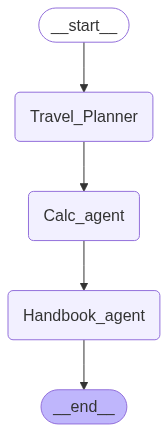

In [17]:
from IPython.display import Image, display
# Mermaid 시각화
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("그래프 시각화 실패:", e)
    print(graph.get_graph().draw_mermaid())  # 소스코드 출력

In [18]:
user_input = "나는 문화와 예술, 건축을 사랑해서 친구와 둘이서 6월 23일부터 25일까지 프랑스 파리를 여행할 예정이야. 파리 근교를 포함해 인기 많은 여행지 위주의 일일 여행 코스를 추천해 줘."
response = graph.invoke({"user_input" : user_input})
print("✅ Travel-Agent 의 작업이 완료되었습니다.")

🗺️ 여행 일정을 생성합니다.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[🛠️ weather_search] Call #1 - Called with input: 'Paris, France'
[🛠️ serper_places] Call #1 - Called with input: 'popular cultural and artistic sites in Paris'
[🛠️ serper_places] Call #2 - Called with input: 'popular architectural sites in Paris and nearby'
[✅ weather_search] Call #1 - Success. Result: In Paris, France, the current weather is as follows:
Detailed status: clear sky
Wind speed: 1.54 m/s, direction: 350°
Humidity: 85%
Temperature: 
  - Current: 12.35°C
  - High: 13.28°C
  - Low: 10.77°C
  - Feels like: 11.86°C
Rain: {}
Heat index: None
Cloud cover: 0%
[✅ serper_places] Call #1 - Success. Result: No good Google Search Result was found[✅ serper_places] Call #2 - Success. Result: No good Google Search Result was found



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[🛠️ tavily_search] Call #1 - Called with input: {'name': 'tavily_search', 'args': {'query': 'cultural sites in Paris'}, 'id': 'call_tS6lSMPtFTYXpIdmtYzKUlZ3', 'type': 'tool_call'}
[🛠️ tavily_search] Call #2 - Called with input: {'name': 'tavily_search', 'args': {'query': 'architectural sites in Paris and nearby'}, 'id': 'call_oRFI5tzOqloH7Zwr4Bnimnkb', 'type': 'tool_call'}
[🛠️ tavily_search] Call #3 - Called with input: {'name': 'tavily_search', 'args': {'query': 'artistic sites in Paris'}, 'id': 'call_wZIAc2J9dATUd7Mrj8W8ztZB', 'type': 'tool_call'}
[❌ tavily_search] Call #2 - API Error in result: content="HTTPError('502 Server Error: Bad Gateway for url: https://api.tavily.com/search')" name='tavily_search' tool_call_id='call_oRFI5tzOqloH7Zwr4Bnimnkb' artifact={}
[❌ tavily_search] Call #3 - API Error in result: content="HTTPError('502 Server Error: Bad Gateway for url: https://api.tavily.com/search')" name='tavily_search' tool_call_id='call_wZIAc2J9dATUd7Mrj8W8ztZB' artifact={}
[✅ tav

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[🛠️ serper_places] Call #3 - Called with input: 'famous cultural landmarks in Paris'[🛠️ serper_places] Call #4 - Called with input: 'particularly focused on art and architecture'

[✅ serper_places] Call #3 - Success. Result: No good Google Search Result was found
[✅ serper_places] Call #4 - Success. Result: No good Google Search Result was found


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📝 Markdown 저장 완료: ../output/plan.md
🧮 여행 비용을 계산합니다.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[🛠️ tavily_search] Call #4 - Called with input: {'name': 'tavily_search', 'args': {'query': 'Louvre Museum entrance fee in Korean Won'}, 'id': 'call_dBItrl7smNG6xegLOJZfAP9k', 'type': 'tool_call'}
[🛠️ tavily_search] Call #5 - Called with input: {'name': 'tavily_search', 'args': {'query': "Musée d'Orsay entrance fee in Korean Won"}, 'id': 'call_nMkKfWp2U58aeX6ZfjBHm0Sq', 'type': 'tool_call'}
[🛠️ tavily_search] Call #6 - Called with input: {'name': 'tavily_search', 'args': {'query': 'Eiffel Tower entrance fee in Korean Won'}, 'id': 'call_t8zCgLDzdE7CfxY4mGta7tVM', 'type': 'tool_call'}
[❌ tavily_search] Call #5 - API Error in result: content="HTTPError('502 Server Error: Bad Gateway for url: https://api.tavily.com/search')" name='tavily_search' tool_call_id='call_nMkKfWp2U58aeX6ZfjBHm0Sq' artifact={}
[❌ tavily_search] Call #4 - API Error in result: content="HTTPError('502 Server Error: Bad Gateway for url: https://api.tavily.com/search')" name='tavily_search' tool_call_id='call_dBItrl7smN

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[🛠️ serper_search] Call #1 - Called with input: 'current exchange rate EUR to KRW'
[🛠️ serper_search] Call #2 - Called with input: 'Louvre Museum entrance fee'
[🛠️ serper_search] Call #3 - Called with input: "Musée d'Orsay entrance fee"
[🛠️ serper_search] Call #4 - Called with input: 'Eiffel Tower entrance fee'
[✅ serper_search] Call #4 - Success. Result: Rates and opening times to visit the Eiffel Tower. Prices: €14,20 to €35.30 maximum for adults and €3,60 to €17.70 for children and young people. Discover or visit the tower: buy a ticket (11.8 to 29.4 € maximum for adults and 3 to 14.7 € for children and young people), news and practical informatio
[✅ serper_search] Call #2 - Success. Result: Opening hours and prices for the Louvre, Tuileries Garden and Musée National Eugène-Delacroix. Admission to the Musée du Louvre and the Musée National Eugène-Delacroix is free upon presentation of valid proof of eligibility. See free admission conditions. Admission to the Musée du Louvre and the

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📝 Markdown 저장 완료: ../output/cost.md
🗒️ 여행용 핸드북을 생성합니다.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📝 Markdown 저장 완료: ../output/handbook.md
🌐 HTML 저장 완료: ../output/handbook.html
✅ Travel-Agent 의 작업이 완료되었습니다.
